In [1]:
import pickle 
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
from epiweeks import Week
import properscoring as ps
from datetime import datetime
from datetime import datetime
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error as mse

In [2]:
PATH_LSTM = '../predictions/lstm'
PATH_PGBM = '../predictions/pgbm'

In [3]:
def skill_score_mse(forecast, reference, target):
    '''
    Compute the skill score using the RMSE 
    '''
    
    rmse_f = mse(target, forecast, squared = False )
    
    rmse_r = mse(target, reference, squared = False)
    
    return 1 - (rmse_f/rmse_r)


def compute_crps(file,  ini_evaluate = '2022-11-06',
                    end_evaluate = '2023-10-22'): 
    '''
    Function to compute the crps of the ensemble output of the DL models 
    '''
    
    with open(file, 'rb') as f:
        data = pickle.load(f)

    ini_index = data['indice'].index(datetime.strptime(ini_evaluate, '%Y-%m-%d').date()) - 55
    end_index = data['indice'].index(datetime.strptime(end_evaluate, '%Y-%m-%d').date()) - 55

    ensemble = data['factor']*data['ensemble'][ini_index:end_index,-1, ]
    obs = data['factor']*data['target'][ini_index:end_index,-1]

    return ps.crps_ensemble(obs, ensemble).mean()



def skill(baseline_score, forecast_score):
    '''
    This function is used with the compute_crps to compute the skill usin the crps metric 
    '''
    return (baseline_score - forecast_score) / baseline_score


In [4]:
def get_preds(path = f'../../predictions/lstm/lstm_2211001_chik_predictions_msle.pkl', label = 'dengue_model', cor_idx= 55):
    '''
    Get the prediction from the lstm models and transform it in a dataframe. 
    '''
    with open(path, 'rb') as f:
        data = pickle.load(f)

    df = pd.DataFrame()
    
    df['date'] = data['indice'][55:]
    
    df[f'target_{label}'] = data['target'][:,-1]*data['factor']
    
    df[f'lower_{label}'] = data['lb'].iloc[:,-1]*data['factor']
    
    df[f'preds_{label}'] = data['pred'].iloc[:,-1]*data['factor']
    
    df[f'upper_{label}'] = data['ub'].iloc[:,-1]*data['factor']
    
    df.set_index('date',inplace = True)
    
    df.index = pd.to_datetime(df.index)
    
    return df

In [5]:
city = 2913606
ini_evaluate = '2022-11-01'
end_evaluate = '2023-11-01'

In [18]:
def get_chik_data(city, ini_date = '2022-11-01', end_date = '2023-11-01'):
    '''
    Crate a single dataframe with all the lstm chik predictions: 
    * using the dengue model;
    * using the transf model; 
    * using the chik model. 
    '''
    
    d1 = get_preds(f'{PATH_LSTM}/lstm_{city}_chik_predictions_msle.pkl', label = 'dengue_model')
    
    d2 = get_preds(f'{PATH_LSTM}/tl_{city}_chik_transf_msle.pkl', label = 'transf_model')

    d3 = get_preds(f'{PATH_LSTM}/lstm_{city}_chik_msle.pkl', label = 'chik_model')
    
    d = d1.merge(d2, left_index=True, right_index=True).merge(d3, 
    left_index=True, right_index=True)

    d['target'] = d['target_dengue_model']

    d = d.drop(['target_dengue_model', 'target_transf_model',
           'target_chik_model'], axis = 1)
    
    d = d.loc[ (d.index >= ini_date) & (d.index <= end_date )]

    return d


def get_chik_data_pgbm(city, ini_date = '2022-11-01', end_date = '2023-11-01'):
    '''
    Crate a single dataframe with the transf and the pgbm chik predictions: 
    * using the dengue model (pgbm);
    * using the transf model; 
    * using the chik model (pgbm). 
    '''
    
    d1 = get_preds(f'{PATH_PGBM}/pgbm_{city}_chik_cross_predictions_msle.pkl', label = 'dengue_model')
    
    d2 = get_preds(f'{PATH_LSTM}/tl_{city}_chik_transf_msle.pkl', label = 'transf_model')

    d3 = get_preds(f'{PATH_PGBM}/pgbm_{city}_chik_predictions.pkl', label = 'chik_model')
    
    d = d1.merge(d2, left_index=True, right_index=True).merge(d3, 
    left_index=True, right_index=True)

    d['target'] = d['target_dengue_model']

    d = d.drop(['target_dengue_model', 'target_transf_model',
           'target_chik_model'], axis = 1)
    
    d = d.loc[ (d.index >= ini_date) & (d.index <= end_date )]

    return d


In [13]:
def plot_comp(ax, city, ini_evaluate = '2022-11-01', end_evaluate = '2023-11-01', model = 'DL'): 
    '''
    Function to compare the predictions in a given interval and compute the ss. 
    If the model is DL it's used the lstm model and is computed the skill score using crps 
    '''
    
    df = get_chik_data(city, ini_date = ini_evaluate,
                             end_date = end_evaluate)

    ax.plot(df.index, df.target , color = 'black', label = 'Data', linewidth=2)

    ax.plot(df.index, df.preds_dengue_model, label = f'{model} - Dengue', color = 'tab:blue', ls = 'dashed', linewidth=2)
    
    ax.fill_between(df.index, df.lower_dengue_model,
                    df.upper_dengue_model,  color = 'tab:blue',
                    alpha = 0.2)
    
    
    ax.plot(df.index, df.preds_transf_model, label = f'TL', linewidth=2,
                        color = 'tab:red', ls = 'dashdot')
    
    ax.fill_between(df.index, df.lower_transf_model, 
                    df.upper_transf_model,
                        color = 'tab:red', alpha = 0.2)
    
    ax.set_xlabel('Date')
    
    ax.set_ylabel('New cases')
    
    ax.plot(df.index, df.preds_chik_model, label = f'{model} - Chik',color = 'tab:orange', ls = 'dotted', linewidth=2)
    
    ax.fill_between(df.index, df.lower_chik_model,
                   df.upper_chik_model, alpha = 0.2, color = 'tab:orange')


    ax.grid()
    
    ax.legend()
    
    ax.set_title(f'Chikungunya forecasts at {city} ({model})')
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(20)
        
    print('Skill score using RMSE')
        
    print('TL vs DL - dengue:', skill_score_mse(forecast = df.preds_transf_model, 
                                            reference = df.preds_dengue_model, 
                                            target = df.target))
    
    print('TL vs DL - chik:', skill_score_mse(forecast = df.preds_transf_model, 
                                            reference = df.preds_chik_model, 
                                            target = df.target))

    if model == 'DL':
        
        print('Skill score using CRPS')
        
        crps1 = compute_crps(f'{PATH_LSTM}/lstm_{city}_chik_predictions_msle.pkl',
                             ini_evaluate = ini_evaluate,
                             end_evaluate = end_evaluate)
    
        crps2 = compute_crps(f'{PATH_LSTM}/tl_{city}_chik_transf_msle.pkl',
                            ini_evaluate = ini_evaluate,
                             end_evaluate = end_evaluate)

        crps3 = compute_crps(f'{PATH_LSTM}/lstm_{city}_chik_msle.pkl',
                            ini_evaluate = ini_evaluate,
                             end_evaluate = end_evaluate)

        print('TL vs DL - dengue:', skill(baseline_score = crps1, 
                                          forecast_score = crps2))

        print('TL vs DL - chik:', skill(baseline_score = crps3, 
                                          forecast_score = crps2))

    return
    

Skill score using RMSE
TL vs DL - dengue: -0.1415478904493288
TL vs DL - chik: 0.12662825445544557
Skill score using CRPS
TL vs DL - dengue: -0.18338049290662067
TL vs DL - chik: 0.16889177638212632


/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_3530/626820003.py:19: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ini_index = data['indice'].index(datetime.strptime(ini_evaluate, '%Y-%m-%d').date()) - 55
/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_3530/626820003.py:20: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  end_index = data['indice'].index(datetime.strptime(end_evaluate, '%Y-%m-%d').date()) - 55


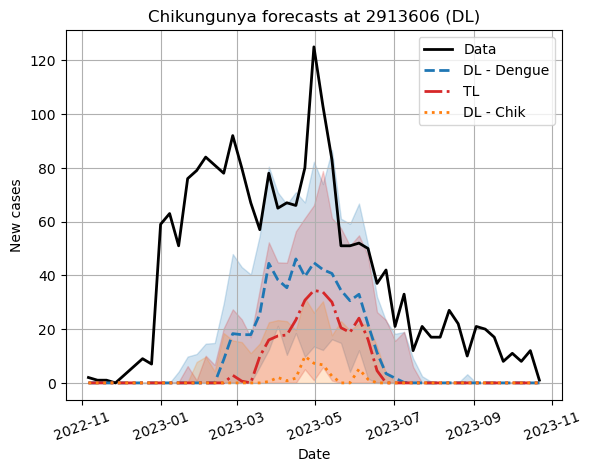

In [14]:
fig, ax = plt.subplots()

plot_comp(ax, city, ini_evaluate = '2022-11-06', end_evaluate = '2023-10-22')

## New qq plot:

In [15]:
def gen_data_to_qq(city, ini_evaluate,end_evaluate):
    
    df_end = pd.DataFrame()
    
    df = get_chik_data(city, ini_date = ini_evaluate,
                             end_date = end_evaluate)


    df_end['dates'] = df.index
    df_end['dates'] = pd.to_datetime(df_end['dates'])
    df_end['week'] = [Week.fromdate(i).weektuple()[1] for i in df_end['dates']] 
    df_end['target_chik'] = df['target'].values
    df_end['preds_dl_dengue'] =  df['preds_dengue_model'].values
    
    df_end['preds_tl'] =  df['preds_chik_model'].values

    df_end['preds_dl_chik'] = df['preds_chik_model'].values
    
    # adicionando os dados de dengue: 
    
    df_dengue = pd.read_csv(f'../data/dengue_{city}_cluster.csv', index_col = 'Unnamed: 0' , usecols = ['Unnamed: 0', f'casos_{city}'])
    
    
    df_dengue.index = pd.to_datetime(df_dengue.index)
    
    df_dengue['week'] = [Week.fromdate(i).weektuple()[1] for i in df_dengue.index] 
    
    df_dengue['year'] = [Week.fromdate(i).weektuple()[0] for i in df_dengue.index]
    
    #adicionando data faltando 
    
    v = ( df_dengue.loc['2018-04-01'][f'casos_{city}'] + df_dengue.loc['2018-04-15'][f'casos_{city}'] )/2
    
    f = {f'casos_{city}':v, 'week':15 , 'year':2018}
    
    
    s = pd.DataFrame(f, index=['2018-04-08'])
    
    df_dengue = df_dengue.append(s)
 
    df_dengue.index = pd.to_datetime(df_dengue.index)
    
    df_dengue = df_dengue.sort_index()
    
    
    for y in np.arange(2010, max(df_end.dates.dt.year)):
        
        df_s = df_dengue.loc[df_dengue.year == y]
        
        try:

            df_end[f'dengue_{y}'] = df_s.loc[ df_s.week.isin(df_end.week)][f'casos_{city}'].values
            
        except:
                        
            print('Erro para o ano:')
            print(y)
    


    
    return df_end

In [16]:
def plot_cross_qq(ax, q_o, q_p, title):
    sns.kdeplot(x = q_o[len(q_p) - len(q_o):], y = q_p, ax =ax, fill = True)
    ax.set_xlabel('observed')
    ax.set_ylabel('predicted')
    
    max_v = max( max(q_p), max(q_o))
    
    ax.set_xlim([0, max_v])
    ax.set_ylim([0, max_v])
    ax.plot([0, 100], [0, 100], 'k')
    
    ax.set_title(f'{title} - p.25: {round(np.percentile(q_p - q_o, 25),2)} - p.50: {round(np.median(q_p - q_o), 2)} - p.75: {round(np.percentile(q_p - q_o, 75), 2)}')
    #P.title(f'Transfer prediction percentiles with {model_name.lower()} for {doenca} at {city_name}')

def gen_qq_plot(city, ini_evaluate, end_evaluate):
    
    df =  gen_data_to_qq(city, ini_evaluate, end_evaluate)
    
    cols = df.columns[ df.columns.str.startswith('dengue')]
    
    obs_preds = df[cols].values

    chik = df['target_chik'].values

    pred_tl = df['preds_tl'].values

    pred_dl_dengue = df['preds_dl_dengue'].values
    
    pred_dl_chik = df['preds_dl_chik'].values

    q_o = ss.percentileofscore(obs_preds, chik)

    q_p_dl_dengue = ss.percentileofscore(obs_preds, pred_dl_dengue)
    
    q_p_dl_chik = ss.percentileofscore(obs_preds, pred_dl_chik)

    q_p_tl = ss.percentileofscore(obs_preds, pred_tl)
    
    fig, ax = plt.subplots(1,3, figsize = (12,4))

    fig.suptitle(f'City - {city}', fontsize=12)
    
    plot_cross_qq(ax[0], q_o, q_p_tl, title = 'TL')

    plot_cross_qq(ax[1], q_o, q_p_dl_dengue, title = 'DL - dengue')
    
    plot_cross_qq(ax[2], q_o, q_p_dl_dengue, title = 'DL - chik')
    
    plt.savefig(f'qq_plot_{city}.png', dpi = 300, bbox_inches = 'tight')
    
    plt.tight_layout()
    
    plt.show()
    
    return


/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_3530/3096949439.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dengue = df_dengue.append(s)


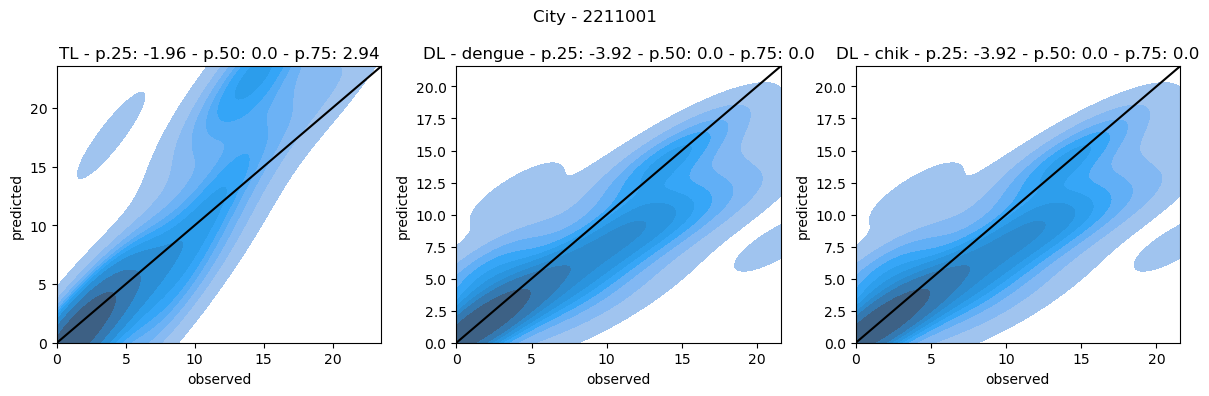

In [17]:
gen_qq_plot(city = 2211001, ini_evaluate = '2022-11-01', end_evaluate = '2023-11-01')